In [1]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy.io as spio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

from modules.elbo import ELBO

import os

### Setup parameters

In [2]:
# load sample trajectory
sim_idx = 0 # which out of the 100 trajectories to use
data_path = Path('data')
f_name = 'sim_0090.mat'
S = spio.loadmat(Path(data_path) / f_name)['S']
S_list = [S[0, i] for i in range(S.shape[1])]  # convert to list of structs

# unpack data
n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
n_dim = S_list[sim_idx]['x'][0, 0].shape[0]

### Run inference

In [3]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=40000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Iteration 1 | Loss: 692.6966732591391
Iteration 2 | Loss: 775.172445319593
Current loss: 723.880158290267
Loss updated
Iteration 3 | Loss: 723.880158290267
Current loss: 713.0119096785784
Loss updated
Iteration 4 | Loss: 713.0119096785784
Current loss: 736.957731589675
Iteration 5 | Loss: 736.957731589675
Current loss: 766.2031362876296
Iteration 6 | Loss: 766.2031362876296
Current loss: 734.5839160606265
Iteration 7 | Loss: 734.5839160606265
Current loss: 701.7449324131012
Loss updated
Iteration 8 | Loss: 701.7449324131012
Iteration 9 | Loss: 720.8897829800844
Current loss: 701.6976072192192
Loss updated
Iteration 10 | Loss: 701.6976072192192
Epoch: 0, Loss: 1256.6698758965917
Epoch: 250, Loss: 1187.868813692572
Epoch: 500, Loss: 1107.1882398872856
Epoch: 750, Loss: 1075.6395441841137
Epoch: 1000, Loss: 1034.0369512089915
Epoch: 1250, Loss: 999.8047544944092
Epoch: 1500, Loss: 993.7533388353162
Epoch: 1750, Loss: 949.810968

#### Load final model and plot error curves

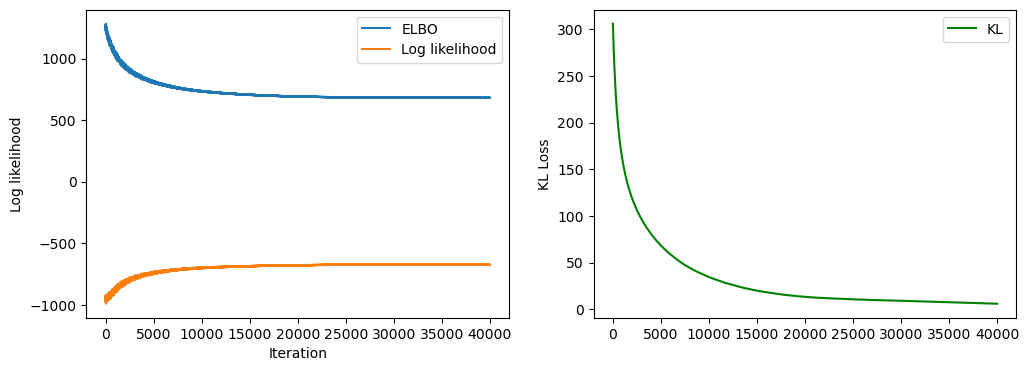

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Primary y-axis (ELBO and Neg. log likelihood)
axs[0].plot(errors, label='ELBO')
axs[0].plot(ll_loss, label='Log likelihood')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Log likelihood')
# axs[0].set_yscale('log')
# axs[0].tick_params(axis='y')

axs[1].plot(kl_loss, label='KL', color='green')
axs[1].set_ylabel('KL Loss')
# axs[1].tick_params(axis='y')
# axs[1].set_yscale('log')

# Add legends for both axes
axs[0].legend()
axs[1].legend()

# save and show the plot
# fig.suptitle('Loss over iterations')
# plt.savefig(Path(out_dict) / f"error_{sim_curvature}")
# plt.show()

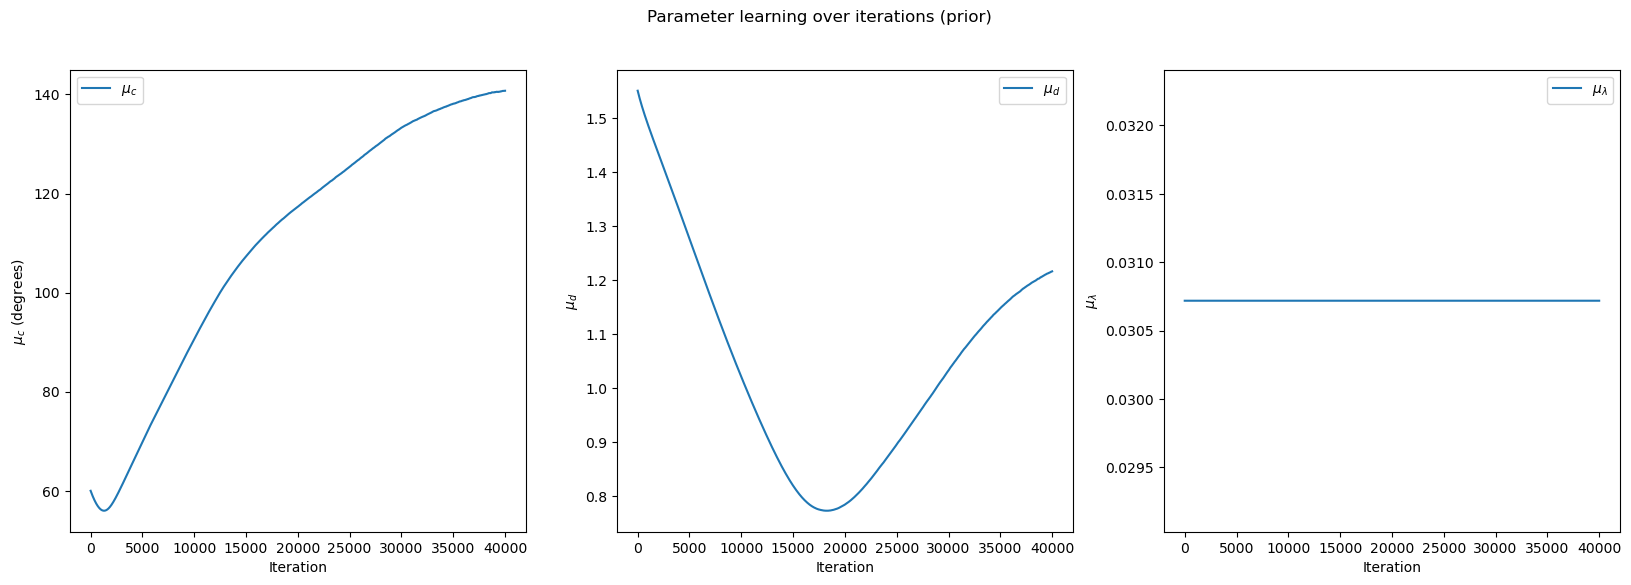

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/56/7xrzykp553j4850_g_vdc8mr0000gn/T/ipykernel_60148/2295650332.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post.T)


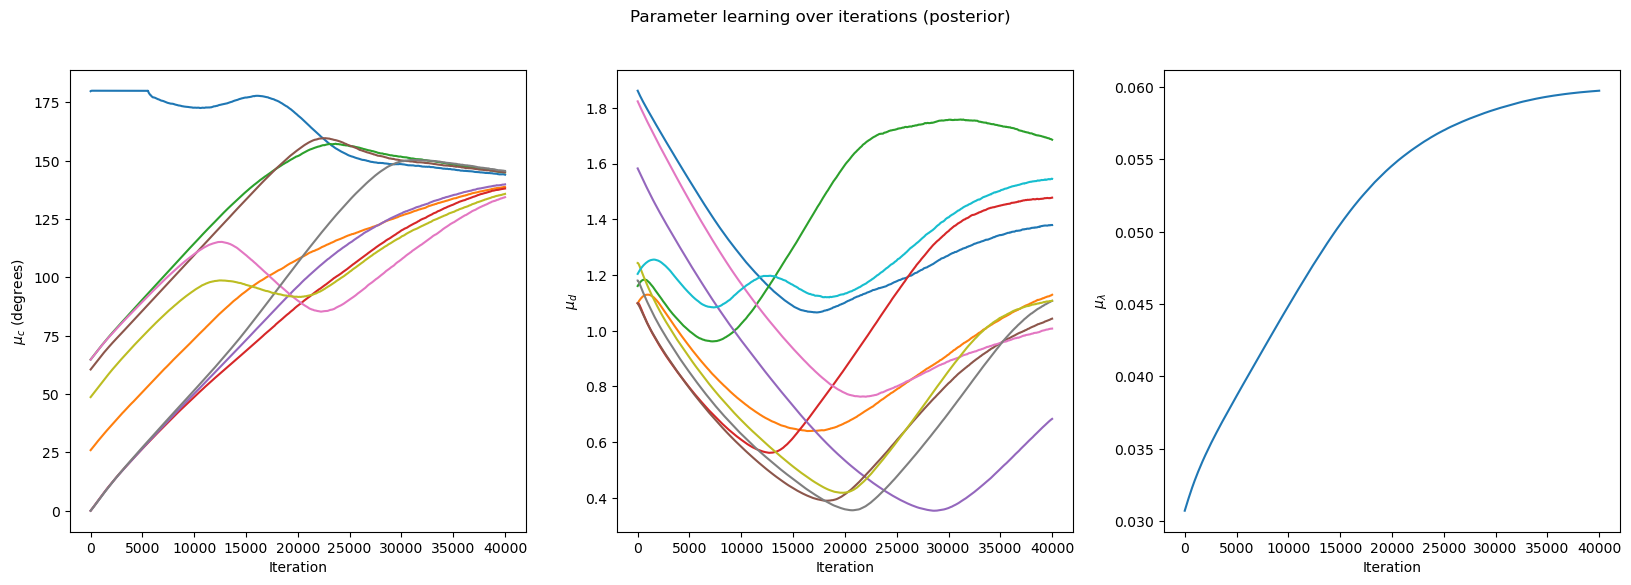

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

### Reconstruct trajectory

In [7]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 140.7431182861328 degrees
Average estimated local curvature: 140.74459616633985 degrees


In [8]:
# compute PC-reduced perceptual locations
pca_true = PCA(n_components=2)
pca_fit = PCA(n_components=2)

# ground truth perceptual locations
pca_true.fit(S_list[sim_idx]['x'][0, 0])
pc_true = pca_true.components_

pca_fit.fit(x.squeeze().detach())
pc_fit = pca_fit.components_

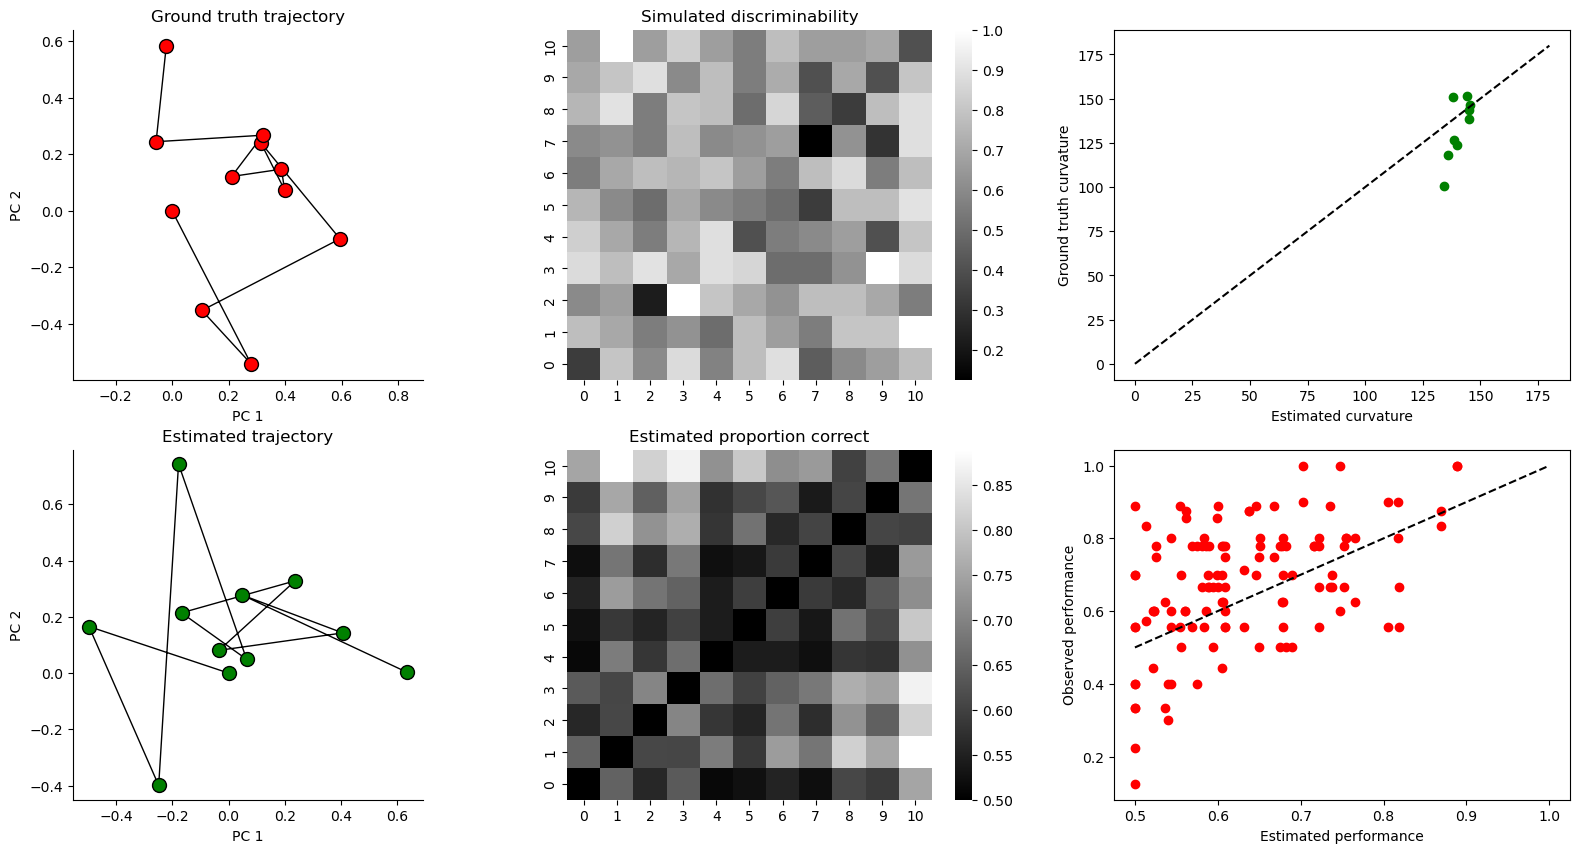

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].plot(pc_true[0, :], pc_true[1, :], '-ko', markersize=10, markerfacecolor='r', linewidth=1)
axs[0, 0].set_title('Ground truth trajectory')
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')
axs[0, 0].set_box_aspect(1)  
axs[0, 0].set_aspect('equal') 
axs[0, 0].spines['top'].set_visible(False)  
axs[0, 0].spines['right'].set_visible(False)

sns.heatmap(S_list[sim_idx]['Pc_reshaped'][0, 0], ax=axs[0, 1], cmap='gray')
axs[0, 1].invert_yaxis()
axs[0, 1].set_title('Simulated discriminability')

axs[0, 2].plot(torch.flatten(torch.rad2deg(elbo.mu_post_c)).detach(), np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 'go')
axs[0, 2].plot([0, 180], [0, 180], 'k--')
axs[0, 2].set_xlabel('Estimated curvature')
axs[0, 2].set_ylabel('Ground truth curvature')

axs[1, 0].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[1, 0].set_title('Estimated trajectory')
axs[1, 0].set_xlabel('PC 1')
axs[1, 0].set_ylabel('PC 2')
axs[1, 0].set_box_aspect(1)  
axs[1, 0].set_aspect('equal') 
axs[1, 0].spines['top'].set_visible(False)  
axs[1, 0].spines['right'].set_visible(False)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 1], cmap='gray')
axs[1, 1].invert_yaxis()
axs[1, 1].set_title('Estimated proportion correct')

axs[1, 2].plot(p.flatten().detach(), S_list[sim_idx]['Pc_reshaped'][0, 0].flatten(), 'ro')
axs[1, 2].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 2].set_xlabel('Estimated performance')
axs[1, 2].set_ylabel('Observed performance')

plt.show()